<a href="https://colab.research.google.com/github/iuliastremciuc/DS-Unit-2-Kaggle-Challenge/blob/master/module1-decision-trees/IS_221_LS_DS_221_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [ ] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition. Notice that the Rules page also has instructions for the Submission process. The Data page has feature definitions.
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Begin with baselines for classification.
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [456]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [475]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [476]:
# Check Pandas Profiling version
import pandas_profiling
pandas_profiling.__version__

'2.5.0'

In [0]:
# Old code for Pandas Profiling version 2.3
# It can be very slow with medium & large datasets.
# These parameters will make it faster.

# profile = train.profile_report(
#     check_correlation_pearson=False,
#     correlations={
#         'pearson': False,
#         'spearman': False,
#         'kendall': False,
#         'phi_k': False,
#         'cramers': False,
#         'recoded': False,
#     },
#     plot={'histogram': {'bayesian_blocks_bins': False}},
# )
#

# New code for Pandas Profiling version 2.4
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

profile

In [0]:
#columns are duplicates, or nearly duplicates
train = train.drop(['id', 'amount_tsh', 'num_private', 'extraction_type',	'extraction_type_group', 'management_group', 'payment', 'water_quality', 'quantity_group', 'source_type', 'waterpoint_type_group'], axis = 1)

In [0]:
train['date_recorded'] = pd.to_datetime(train['date_recorded'], infer_datetime_format= True)
how_old = train['date_recorded'].dt.year - train['construction_year']
train['how_old'] = how_old
test['date_recorded'] = pd.to_datetime(test['date_recorded'], infer_datetime_format= True)
how_old = test['date_recorded'].dt.year - test['construction_year']
test['how_old'] = how_old

In [479]:
#Do train/validate/test split with the Tanzania Waterpumps data.
#split into train and val
train, val = train_test_split(train, train_size = 0.80, test_size = 0.20, stratify = train['status_group'], random_state = 42)
train.shape, val.shape

((47520, 31), (11880, 31))

In [480]:
#Begin with baselines for classification.
train['status_group'].value_counts(normalize = True)

functional                 0.543077
non functional             0.384238
functional needs repair    0.072685
Name: status_group, dtype: float64

In [463]:
print(train.shape)
train.head()

(47520, 31)


,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type_class,management,payment_type,quality_group,quantity,source,source_class,waterpoint_type,status_group,how_old
43360,2011-07-27,NaN,0,NaN,33.542898,-9.174777,Kwa Mzee Noa,Lake Nyasa,Mpandapanda,Mbeya,12,4,Rungwe,Kiwira,0,True,GeoData Consultants Ltd,VWC,K,NaN,0,gravity,vwc,never pay,good,insufficient,spring,groundwater,communal standpipe,functional,2011
7263,2011-03-23,Rc Church,2049,ACRA,34.665760,-9.308548,Kwa Yasinta Ng'Ande,Rufiji,Kitichi,Iringa,11,4,Njombe,Imalinyi,175,True,GeoData Consultants Ltd,WUA,Tove Mtwango gravity Scheme,True,2008,gravity,wua,monthly,good,enough,spring,groundwater,communal standpipe,functional,3
2486,2011-03-07,Donor,290,Do,38.238568,-6.179919,Kwasungwini,Wami / Ruvu,Kwedigongo,Pwani,6,1,Bagamoyo,Mbwewe,2300,True,GeoData Consultants Ltd,VWC,NaN,False,2010,handpump,vwc,per bucket,salty,insufficient,shallow well,groundwater,hand pump,functional,1
313,2011-07-31,Government Of Tanzania,0,DWE,30.716727,-1.289055,Kwajovin 2,Lake Victoria,Kihanga,Kagera,18,1,Karagwe,Isingiro,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,other,vwc,never pay,good,enough,shallow well,groundwater,other,non functional,2011
52726,2011-03-10,Water,0,Gove,35.389331,-6.399942,Chama,Internal,Mtakuj,Dodoma,1,6,Bahi,Nondwa,0,True,GeoData Consultants Ltd,VWC,Zeje,True,0,motorpump,vwc,per bucket,good,enough,machine dbh,groundwater,communal standpipe,functional,2011


In [455]:
train['amount_tsh'].value_counts()

0.0         33265
500.0        2496
50.0         1970
1000.0       1207
20.0         1186
            ...  
138000.0        1
14000.0         1
16000.0         1
4500.0          1
12.0            1
Name: amount_tsh, Length: 94, dtype: int64

In [0]:
train['construction_year'].value_counts()

In [445]:
train.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type_class,management,payment_type,quality_group,quantity,source,source_class,waterpoint_type,status_group,how_old
35240,200.0,2011-03-09,NaN,1757,Angli,34.588740,-9.786994,none,Lake Nyasa,Kiyombo,Iringa,11,5,Ludewa,Mlangali,75,True,GeoData Consultants Ltd,VWC,Anglic,False,2001,gravity,vwc,monthly,good,enough,spring,groundwater,communal standpipe,functional,10
16282,0.0,2011-08-21,Rudep,1664,DWE,31.739103,-8.771693,Mzee Selekete,Lake Rukwa,Mula,Rukwa,15,2,Sumbawanga Rural,Mwimbi,300,True,GeoData Consultants Ltd,VWC,NaN,False,1994,handpump,vwc,never pay,good,enough,shallow well,groundwater,hand pump,functional,17
57019,0.0,2011-07-28,Danida,0,Central government,33.922908,-9.499151,Kwa Baleke Mbila,Lake Nyasa,Mpugupugu,Mbeya,12,3,Kyela,Lusungo,0,True,GeoData Consultants Ltd,VWC,Ngamanga water supplied sch,True,0,gravity,vwc,monthly,good,enough,spring,groundwater,communal standpipe,functional,2011
30996,0.0,2013-03-26,Mission,1532,Mission,34.820269,-11.108757,Shuleni,Lake Nyasa,Makugulu 'A',Ruvuma,10,3,Mbinga,Mikalanga,260,NaN,GeoData Consultants Ltd,WUG,Government,True,2005,gravity,wug,unknown,good,enough,spring,groundwater,communal standpipe,functional needs repair,8
21149,50.0,2011-03-19,Private Individual,-27,Da,38.900501,-6.451608,Pascal,Wami / Ruvu,Bong'Wa,Pwani,6,1,Bagamoyo,Magomeni,20,True,GeoData Consultants Ltd,Company,Bagamoyo wate,True,2009,submersible,private operator,per bucket,good,enough,river,surface,communal standpipe,functional,2


In [422]:
train.describe(exclude = 'number').T.sort_values(by = 'unique')

,count,unique,top,freq,first,last
recorded_by,44550,1,GeoData Consultants Ltd,44550,NaT,NaT
public_meeting,42082,2,True,38275,NaT,NaT
permit,42257,2,True,29099,NaT,NaT
status_group,44550,3,functional,24194,NaT,NaT
source_class,44550,3,groundwater,34365,NaT,NaT
quantity,44550,5,enough,24909,NaT,NaT
quality_group,44550,6,good,38044,NaT,NaT
payment_type,44550,7,never pay,19035,NaT,NaT
extraction_type_class,44550,7,gravity,20085,NaT,NaT
waterpoint_type,44550,7,communal standpipe,21356,NaT,NaT


In [402]:
train.describe()

,amount_tsh,gps_height,longitude,latitude,region_code,district_code,population,construction_year
count,44550.000000,44550.000000,44550.000000,4.455000e+04,44550.000000,44550.000000,44550.000000,44550.000000
mean,324.898325,669.616094,34.080309,-5.715456e+00,15.252391,5.607250,179.684085,1302.070011
std,3281.228067,693.047465,6.558393,2.941760e+00,17.541883,9.597167,462.207597,951.166321
min,0.000000,-63.000000,0.000000,-1.164944e+01,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090018,-8.545223e+00,5.000000,2.000000,0.000000,0.000000
50%,0.000000,372.000000,34.912797,-5.036199e+00,12.000000,3.000000,25.000000,1986.000000
75%,25.000000,1320.000000,37.171335,-3.328885e+00,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.344301,-2.000000e-08,99.000000,80.000000,15300.000000,2013.000000


In [0]:
train.dtypes

In [425]:
train.dtypes

amount_tsh                      float64
date_recorded            datetime64[ns]
funder                           object
gps_height                        int64
installer                        object
longitude                       float64
latitude                        float64
wpt_name                         object
basin                            object
subvillage                       object
region                           object
region_code                       int64
district_code                     int64
lga                              object
ward                             object
population                        int64
public_meeting                   object
recorded_by                      object
scheme_management                object
scheme_name                      object
permit                           object
construction_year                 int64
extraction_type_class            object
management                       object
payment_type                     object


In [483]:
# cleaning data
target = 'status_group'
#train_features = train.drop(columns = [target, 'id', 'payment', 'construction_year', 'num_private'])
#train_features = train.drop(columns = [target])
numeric_features = train_features.select_dtypes(include = 'number').columns.tolist()
cardinality = train_features.select_dtypes(exclude = 'number').nunique()
categorical_features = cardinality[cardinality <= 30].index.tolist()
#categorical_features = ['extraction_type', 'payment_type', 'source_type', 'waterpoint_type']
#features = ['population','longitude', 'latitude', 'extraction_type', 'payment_type', 'source_type', 'scheme_management', 'how_old']
features = numeric_features + categorical_features
print(features)

['gps_height', 'longitude', 'latitude', 'region_code', 'district_code', 'population', 'construction_year', 'how_old', 'basin', 'region', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type_class', 'management', 'payment_type', 'quality_group', 'quantity', 'source', 'source_class', 'waterpoint_type']


In [0]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [467]:
X_train.shape

(47520, 22)

In [489]:
#Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
import category_encoders as ce 
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_regression



pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names = True), 
    SimpleImputer(strategy = 'median'),
#    SelectKBest(score_func=f_regression, k=10),
    DecisionTreeClassifier(min_samples_leaf = 15,random_state = 42)
)

pipeline.fit(X_train, y_train)

print('Train', pipeline.score(X_train, y_train))


y_pred = pipeline.predict(X_test)

Train 0.8166245791245791


In [490]:
#Get your validation accuracy score.
print('Val', pipeline.score(X_val, y_val))

Val 0.7665824915824916


In [470]:
#Get and plot your feature importances.
model = pipeline.named_steps['decisiontreeclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded_col = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_col)
importances

gps_height                                     0.025897
longitude                                      0.090636
latitude                                       0.094280
region_code                                    0.017629
district_code                                  0.029887
                                                 ...   
waterpoint_type_other                          0.139904
waterpoint_type_communal standpipe multiple    0.030882
waterpoint_type_improved spring                0.001096
waterpoint_type_cattle trough                  0.000000
waterpoint_type_dam                            0.000000
Length: 115, dtype: float64

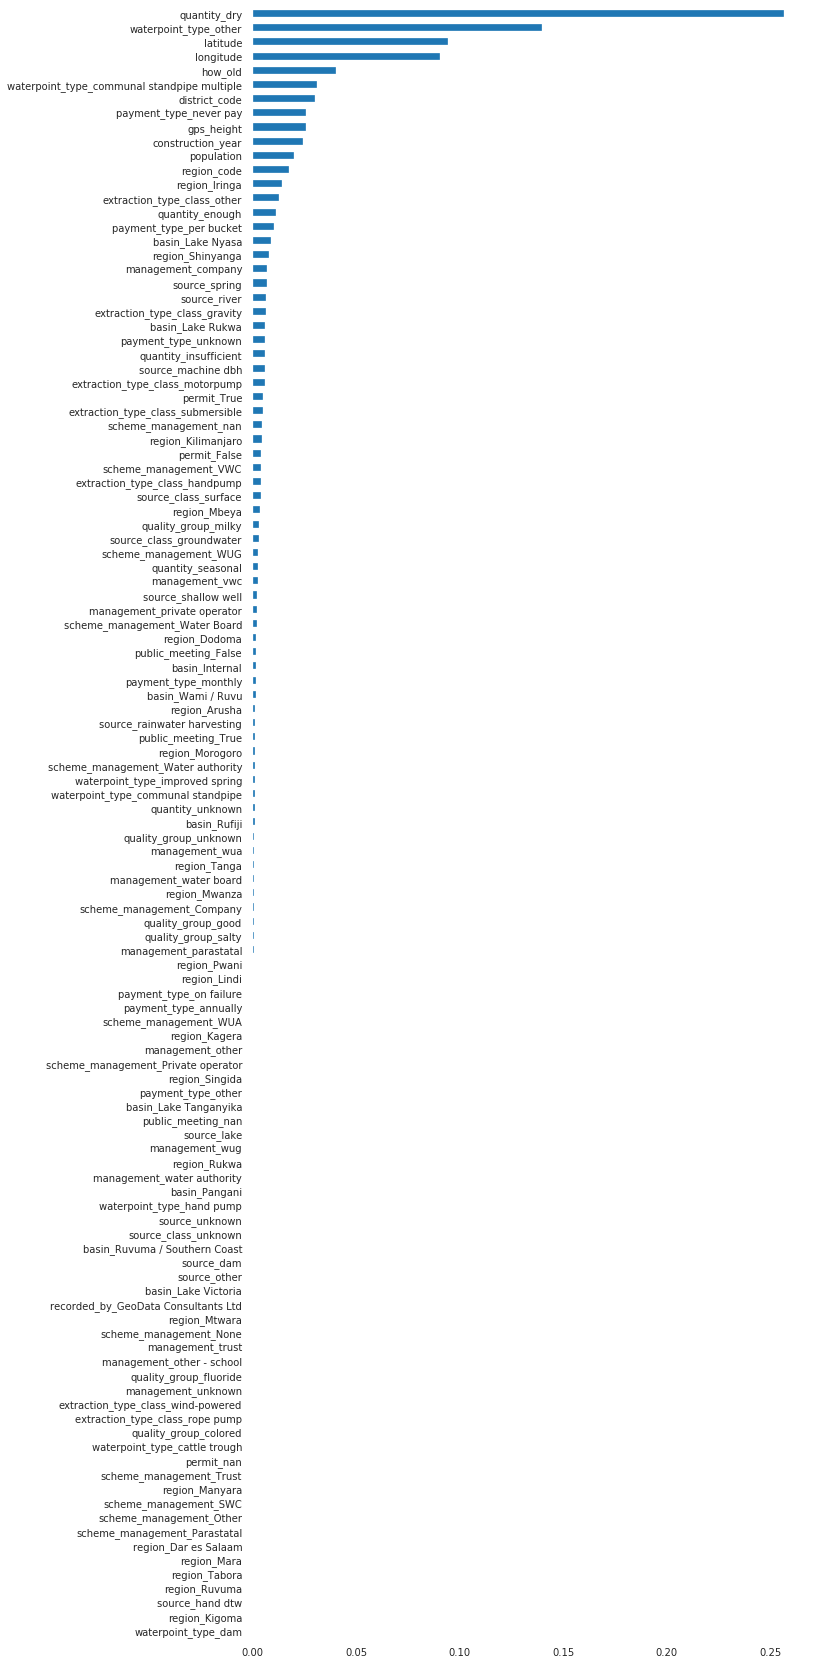

In [471]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 30))
importances.sort_values().plot.barh();

In [0]:
import numpy as np
def wrangle(X):
  X = X.copy()
  X['latitude'] = X['latitude'].replace(-2e-08, 0)
  cols_with_zeros = ['longitude', 'latitude']
  for col in cols_with_zeros:
    X[col] = X[col].replace(0, np.nan)
    X[col] = X.drop(columns = 'quantity_group')
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [472]:
test_id = test['id']
data = {'ID': test_id, 'status_group': y_pred}
first_pred = pd.DataFrame(data)
first_pred

,ID,status_group
0,50785,functional
1,51630,non functional
2,17168,functional
3,45559,non functional
4,49871,functional
...,...,...
14353,39307,functional
14354,18990,non functional
14355,28749,functional
14356,33492,functional


In [0]:
first_pred.to_csv('My_prediction.csv', index = False)

In [474]:
first_pred['status_group'].value_counts()

functional                 8799
non functional             5235
functional needs repair     324
Name: status_group, dtype: int64